Total samples: 1772
Classes: ['cat', 'dog']
Number of training samples: 1417
Number of validation samples: 177
Number of testing samples: 178


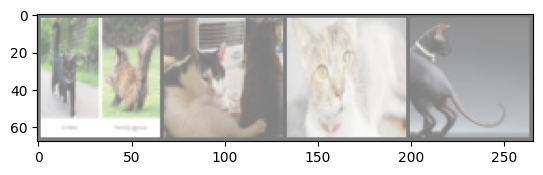

In [14]:
import torch
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),       
])

# 데이터셋 로드
dataset = ImageFolder(root='../Dog_Cat/dataset', transform=transform)

# 데이터셋 크기 확인
print(f"Total samples: {len(dataset)}")

# 데이터셋 분할 (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 클래스 이름 출력
print(f"Classes: {dataset.classes}")

# 데이터 확인
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of testing samples: {len(test_data)}")


# 데이터 확인 (샘플 이미지 시각화)
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))  # 첫 4개 이미지 출력


In [15]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)  # Dropout 추가
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))  # Dropout 적용
        x = self.dropout(self.relu(self.fc2(x)))  # Dropout 적용
        x = self.fc3(x)
        return x



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  

# 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

Epoch 1, Loss: 0.7078162855572171
Epoch 2, Loss: 0.6745821740892198
Epoch 3, Loss: 0.6505925079186757
Epoch 4, Loss: 0.6304037769635519
Epoch 5, Loss: 0.6086783448855082
Epoch 6, Loss: 0.5966781636079153
Epoch 7, Loss: 0.5768986529774136
Epoch 8, Loss: 0.5796865655316247
Epoch 9, Loss: 0.557601347234514
Epoch 10, Loss: 0.558230996131897
Epoch 11, Loss: 0.5284852491484748
Epoch 12, Loss: 0.5451834036244286
Epoch 13, Loss: 0.5257182790173425
Epoch 14, Loss: 0.5402772929933336
Epoch 15, Loss: 0.49795519312222797
Epoch 16, Loss: 0.5413829684257507
Epoch 17, Loss: 0.5699261936876509
Epoch 18, Loss: 0.5608493500285678
Epoch 19, Loss: 0.5078681899441613
Epoch 20, Loss: 0.4719576292567783
Epoch 21, Loss: 0.4623104506068759
Epoch 22, Loss: 0.441611083679729
Epoch 23, Loss: 0.4213369462225172
Epoch 24, Loss: 0.4368934048546685
Epoch 25, Loss: 0.431928989622328
Epoch 26, Loss: 0.46094488402207695
Epoch 27, Loss: 0.4071939296192593
Epoch 28, Loss: 0.3410088578859965
Epoch 29, Loss: 0.3722809159093

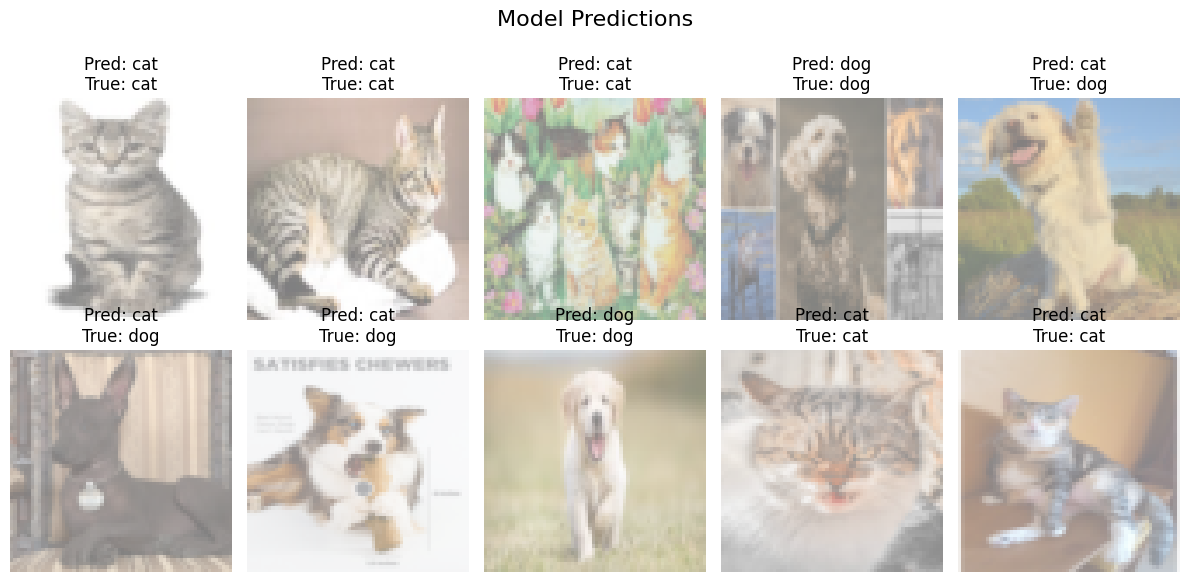

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 클래스 이름 정의 (올바르게 접근)
class_names = train_loader.dataset.dataset.classes  

# 모델 예측값을 시각적으로 확인하는 함수
def imshow(img, ax, title):
    img = img / 2 + 0.5  # 정규화 되돌리기
    npimg = img.cpu().numpy()  # NumPy 배열 변환
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # 차원 변환 (C, H, W) -> (H, W, C)
    ax.set_title(title, fontsize=12)  # 예측 결과를 제목으로 표시
    ax.axis("off")  # 축 숨기기

# 일부 테스트 샘플 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 모델 예측 수행
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택

# 이미지 및 예측 결과 출력
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2x5 레이아웃으로 이미지 배치
fig.suptitle("Model Predictions", fontsize=16)  # 전체 제목 설정

for i, ax in enumerate(axes.flat):
    if i < len(images):
        imshow(images[i], ax, f"Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}")

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 제목과 이미지 간격 조정
plt.show()